# M2608.001300 Machine Learning<br> Assignment #3 Training Convolutional Neural Networks (Pytorch)

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Yeongtak Oh, May 2024

**For understanding of this work, please carefully look at given PPT file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **2 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.


### Some helpful tutorials and references for assignment #3:
- [1] Pytorch official documentation. [[link]](https://pytorch.org/docs/stable/index.html)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

## 1. Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(36, 138, 3)


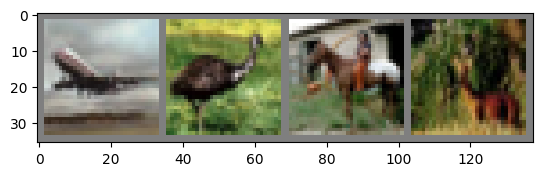

plane  bird horse  deer
torch.Size([3, 32, 32])


In [15]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)

## 2. Training a small CNN model

#### CNN architecture in order:
* 7x7 Convolutional layer with 8 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* 4x4 Convolutional layer with 16 filters, strides of 1, and ReLU activation
* 2x2 Max pooling layer with strides of 2
* Fully connected layer with 100 output units and ReLU activation
* Fully connected layer with 80 output units and ReLU activation
* Fully connected layer with 10 output units and linear activation
* You can use any padding option.

#### Training setup:
* Loss function: Softmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 4 (Things you can try to change)
* Training epoch: 2

In [42]:
# Define a CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 100)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 10)
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten the feature maps
        x = x.view(-1, 16 * 5 * 5)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return x

net = Net()

In [43]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [44]:
# Define a Loss function and optimizer
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

In [45]:
# Function to train the network

def train(net, trainloader, max_epoch, crit, opt, model_path='./cifar_net.pth'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
        
            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [46]:
PATH = './cifar_net.pth'
epoch = 2
train(net, trainloader, epoch, criterion, optimizer, PATH)

[1,  2000] loss: 2.304
[1,  4000] loss: 2.301
[1,  6000] loss: 2.297
[1,  8000] loss: 2.290
[1, 10000] loss: 2.263
[1, 12000] loss: 2.186
[2,  2000] loss: 2.088
[2,  4000] loss: 2.042
[2,  6000] loss: 1.965
[2,  8000] loss: 1.919
[2, 10000] loss: 1.845
[2, 12000] loss: 1.797
Finished Training
Saved Trained Model


In [47]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [48]:
# load trained model then test
net.load_state_dict(torch.load(PATH))
print_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 37 %


## 3. Design a better model on CIFAR-10
Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 70% accuracy on the test set</font>** of CIFAR-10. <br> You can use the implemented *inception class* below.

### Things you can try to change:
- Batch size (input parameter of dataloader)
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles

In [ ]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

In [ ]:
# Define a CNN model
class BetterNet(nn.Module):
    def __init__(self):
        super(BetterNet, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        
        
        
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        
        
        
        
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return out

betternet = BetterNet()
betternet = betternet.to(device)

In [ ]:
# Define a Loss function and optimizer
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        
        
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

In [ ]:
PATH = './better_net.pth'
# Train
train(betternet, trainloader, 2, criterion, optimizer, PATH)
# Test
betternet.load_state_dict(torch.load(PATH))
print_accuracy(betternet, testloader)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

_Tell us here_